# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    tf = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    
    data = datasets.ImageFolder(data_dir, transform = tf)
    
    dataloader = torch.utils.data.DataLoader(data,batch_size, shuffle=True)
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 20
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


In [6]:
len(celeba_train_loader)

4497

In [7]:
len(celeba_train_loader)*batch_size

89940

Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

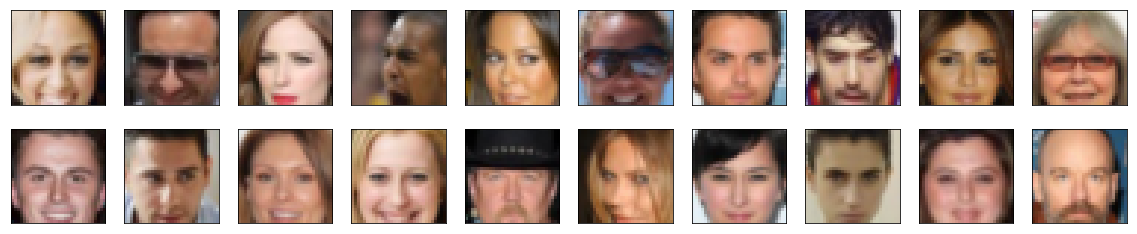

In [8]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [9]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max-min) + min
    return x


In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9843)
Max:  tensor(0.8824)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [11]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
def conv(in_features, out_features, kernel_size=4, stride=2, padding=1, batch_norm=True):
    
    layers = []
    
    layers.append(nn.Conv2d(in_features, out_features, kernel_size, stride, padding))
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_features))
    
    return nn.Sequential(*layers)
    

In [13]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        
        self.conv1 = conv(3,conv_dim)
        self.conv2 = conv(conv_dim,conv_dim*2)
        self.conv3 = conv(conv_dim*2,conv_dim*4)
        self.conv4 = conv(conv_dim*4,conv_dim*8)
        self.conv5 = conv(conv_dim*8,conv_dim*16)
        self.fc = nn.Linear(conv_dim*16,1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        batch_size = x.size(0)
        
        x = self.conv1(x)
        x = F.leaky_relu(x,0.2)
        
        x = self.conv2(x)
        x = F.leaky_relu(x,0.2)
        
        x = self.conv3(x)
        x = F.leaky_relu(x,0.2)
        
        x = self.conv4(x)
        x = F.leaky_relu(x,0.2)
        
        x = self.conv5(x)
        x = F.leaky_relu(x,0.2)
        
        x = x.view(batch_size,-1)
        
        x = self.fc(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [14]:
def deconv(in_features, out_features, kernel_size=4, stride=2, padding=1, batch_norm=True):
    
    layers = []
    
    layers.append(nn.ConvTranspose2d(in_features, out_features, kernel_size, stride, padding))
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_features))
        
    return nn.Sequential(*layers)
    

In [15]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        
        self.fc = nn.Linear(z_size,conv_dim*16)
        self.deconv1 = deconv(conv_dim*16,conv_dim*8)
        self.deconv2 = deconv(conv_dim*8,conv_dim*4)
        self.deconv3 = deconv(conv_dim*4,conv_dim*2)
        self.deconv4 = deconv(conv_dim*2,conv_dim)
        self.deconv5 = deconv(conv_dim,3,batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        batch_size = x.size(0)
        
        x = self.fc(x)
        x = x.view(batch_size,-1,1,1)
        
        x = self.deconv1(x)
        x = F.relu(x)
        
        x = self.deconv2(x)
        x = F.relu(x)
        
        x = self.deconv3(x)
        x = F.relu(x)
        
        x = self.deconv4(x)
        x = F.relu(x)
        
        x = self.deconv5(x)
        x = F.tanh(x)
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [16]:
from torch.nn import init
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    init_type='normal'
    init_gain=0.02
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        if init_type == 'normal':
            init.normal_(m.weight.data, 0.0, init_gain)
        elif init_type == 'xavier':
            init.xavier_normal_(m.weight.data, gain=init_gain)
        elif init_type == 'kaiming':
            init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        elif init_type == 'orthogonal':
            init.orthogonal_(m.weight.data, gain=init_gain)
        else:
            raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
        init.normal_(m.weight.data, 1.0, init_gain)
        init.constant_(m.bias.data, 0.0)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [18]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_featu

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [20]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    loss = torch.mean((D_out-1)**2)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    loss = torch.mean(D_out**2)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [21]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5,0.999))
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5,0.999))

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [22]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            if train_on_gpu:
                real_images = real_images.cuda()
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            d_out = D(real_images)
            d_loss_real = real_loss(d_out)
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            d_out = D(fake_images)
            d_loss_fake = fake_loss(d_out)
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            d_out = D(fake_images)
            
            
            g_loss = real_loss(d_out)
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [28]:
# set number of epochs 
n_epochs = 30


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""


# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   30] | d_loss: 0.5502 | g_loss: 0.4526
Epoch [    1/   30] | d_loss: 0.4530 | g_loss: 0.3402
Epoch [    1/   30] | d_loss: 0.3588 | g_loss: 0.3822
Epoch [    1/   30] | d_loss: 0.5093 | g_loss: 0.3859
Epoch [    1/   30] | d_loss: 0.4732 | g_loss: 0.3213
Epoch [    1/   30] | d_loss: 0.4049 | g_loss: 0.3033
Epoch [    1/   30] | d_loss: 0.5127 | g_loss: 0.3357
Epoch [    1/   30] | d_loss: 0.4072 | g_loss: 0.2843
Epoch [    1/   30] | d_loss: 0.3633 | g_loss: 0.3232
Epoch [    1/   30] | d_loss: 0.3097 | g_loss: 0.4229
Epoch [    1/   30] | d_loss: 0.3583 | g_loss: 0.3911
Epoch [    1/   30] | d_loss: 0.3266 | g_loss: 0.3003
Epoch [    1/   30] | d_loss: 0.3564 | g_loss: 0.3374
Epoch [    1/   30] | d_loss: 0.4166 | g_loss: 0.3192
Epoch [    1/   30] | d_loss: 0.4324 | g_loss: 0.4661
Epoch [    1/   30] | d_loss: 0.4286 | g_loss: 0.3694
Epoch [    1/   30] | d_loss: 0.3514 | g_loss: 0.3928
Epoch [    1/   30] | d_loss: 0.3952 | g_loss: 0.4545
Epoch [    1/   30] | d_loss

Epoch [    2/   30] | d_loss: 0.1921 | g_loss: 0.4451
Epoch [    2/   30] | d_loss: 0.7179 | g_loss: 0.7285
Epoch [    2/   30] | d_loss: 0.1439 | g_loss: 0.8228
Epoch [    2/   30] | d_loss: 0.3076 | g_loss: 0.3777
Epoch [    2/   30] | d_loss: 0.3385 | g_loss: 0.7310
Epoch [    2/   30] | d_loss: 0.3145 | g_loss: 0.7642
Epoch [    2/   30] | d_loss: 0.2897 | g_loss: 0.7432
Epoch [    2/   30] | d_loss: 0.4177 | g_loss: 0.4607
Epoch [    2/   30] | d_loss: 0.3133 | g_loss: 0.2587
Epoch [    2/   30] | d_loss: 0.2718 | g_loss: 0.4701
Epoch [    2/   30] | d_loss: 0.3618 | g_loss: 0.5654
Epoch [    2/   30] | d_loss: 0.3808 | g_loss: 0.6818
Epoch [    2/   30] | d_loss: 0.3180 | g_loss: 0.5578
Epoch [    2/   30] | d_loss: 0.3575 | g_loss: 0.4091
Epoch [    2/   30] | d_loss: 0.2096 | g_loss: 0.4033
Epoch [    2/   30] | d_loss: 0.2686 | g_loss: 0.3474
Epoch [    2/   30] | d_loss: 0.4514 | g_loss: 0.4535
Epoch [    2/   30] | d_loss: 0.2354 | g_loss: 0.6297
Epoch [    2/   30] | d_loss

Epoch [    4/   30] | d_loss: 0.2454 | g_loss: 0.7902
Epoch [    4/   30] | d_loss: 0.3822 | g_loss: 0.4916
Epoch [    4/   30] | d_loss: 0.2222 | g_loss: 0.5799
Epoch [    4/   30] | d_loss: 0.1774 | g_loss: 0.6778
Epoch [    4/   30] | d_loss: 0.1587 | g_loss: 0.4978
Epoch [    4/   30] | d_loss: 0.2695 | g_loss: 0.5148
Epoch [    4/   30] | d_loss: 0.2395 | g_loss: 0.3611
Epoch [    4/   30] | d_loss: 0.4062 | g_loss: 0.7315
Epoch [    4/   30] | d_loss: 0.3990 | g_loss: 0.8345
Epoch [    4/   30] | d_loss: 0.1662 | g_loss: 0.8518
Epoch [    4/   30] | d_loss: 0.1750 | g_loss: 0.6304
Epoch [    4/   30] | d_loss: 0.2325 | g_loss: 0.3873
Epoch [    4/   30] | d_loss: 0.4640 | g_loss: 0.8263
Epoch [    4/   30] | d_loss: 0.4785 | g_loss: 0.5182
Epoch [    4/   30] | d_loss: 0.2140 | g_loss: 0.2551
Epoch [    4/   30] | d_loss: 0.2436 | g_loss: 0.3821
Epoch [    4/   30] | d_loss: 0.2690 | g_loss: 0.4400
Epoch [    4/   30] | d_loss: 0.1416 | g_loss: 0.4470
Epoch [    4/   30] | d_loss

Epoch [    6/   30] | d_loss: 0.1682 | g_loss: 1.0082
Epoch [    6/   30] | d_loss: 0.3809 | g_loss: 0.6738
Epoch [    6/   30] | d_loss: 0.0828 | g_loss: 0.7900
Epoch [    6/   30] | d_loss: 0.3634 | g_loss: 0.8751
Epoch [    6/   30] | d_loss: 0.2793 | g_loss: 0.7864
Epoch [    6/   30] | d_loss: 0.2422 | g_loss: 0.3740
Epoch [    6/   30] | d_loss: 0.2484 | g_loss: 0.2286
Epoch [    6/   30] | d_loss: 0.2416 | g_loss: 0.7252
Epoch [    6/   30] | d_loss: 0.3577 | g_loss: 0.9339
Epoch [    6/   30] | d_loss: 0.1997 | g_loss: 0.8880
Epoch [    6/   30] | d_loss: 0.2917 | g_loss: 0.7737
Epoch [    6/   30] | d_loss: 0.2034 | g_loss: 0.3721
Epoch [    6/   30] | d_loss: 0.1935 | g_loss: 0.6667
Epoch [    6/   30] | d_loss: 0.2832 | g_loss: 0.8284
Epoch [    6/   30] | d_loss: 0.0992 | g_loss: 0.5878
Epoch [    6/   30] | d_loss: 0.1112 | g_loss: 0.9302
Epoch [    6/   30] | d_loss: 0.3696 | g_loss: 0.9303
Epoch [    6/   30] | d_loss: 0.2592 | g_loss: 1.0105
Epoch [    6/   30] | d_loss

Epoch [    7/   30] | d_loss: 0.0686 | g_loss: 0.6732
Epoch [    7/   30] | d_loss: 0.3176 | g_loss: 0.9156
Epoch [    7/   30] | d_loss: 0.1650 | g_loss: 0.4876
Epoch [    7/   30] | d_loss: 0.1838 | g_loss: 1.1872
Epoch [    7/   30] | d_loss: 0.1264 | g_loss: 0.4145
Epoch [    7/   30] | d_loss: 0.2009 | g_loss: 0.9443
Epoch [    7/   30] | d_loss: 0.1817 | g_loss: 0.4356
Epoch [    7/   30] | d_loss: 0.1873 | g_loss: 0.9138
Epoch [    7/   30] | d_loss: 0.3115 | g_loss: 0.7195
Epoch [    7/   30] | d_loss: 0.2793 | g_loss: 0.5066
Epoch [    7/   30] | d_loss: 0.3777 | g_loss: 1.1179
Epoch [    7/   30] | d_loss: 0.0844 | g_loss: 0.8589
Epoch [    7/   30] | d_loss: 0.1910 | g_loss: 0.7401
Epoch [    7/   30] | d_loss: 0.2111 | g_loss: 0.7361
Epoch [    7/   30] | d_loss: 0.1643 | g_loss: 0.7917
Epoch [    7/   30] | d_loss: 0.3004 | g_loss: 0.8511
Epoch [    7/   30] | d_loss: 0.0824 | g_loss: 0.4950
Epoch [    7/   30] | d_loss: 0.2198 | g_loss: 0.4707
Epoch [    7/   30] | d_loss

Epoch [    9/   30] | d_loss: 0.2214 | g_loss: 0.7450
Epoch [    9/   30] | d_loss: 0.1126 | g_loss: 0.9153
Epoch [    9/   30] | d_loss: 0.0912 | g_loss: 0.7598
Epoch [    9/   30] | d_loss: 0.0906 | g_loss: 1.0718
Epoch [    9/   30] | d_loss: 0.1540 | g_loss: 0.9866
Epoch [    9/   30] | d_loss: 0.0965 | g_loss: 0.1988
Epoch [    9/   30] | d_loss: 0.1981 | g_loss: 0.4275
Epoch [    9/   30] | d_loss: 0.1570 | g_loss: 0.9037
Epoch [    9/   30] | d_loss: 0.0864 | g_loss: 0.6178
Epoch [    9/   30] | d_loss: 0.0717 | g_loss: 0.6799
Epoch [    9/   30] | d_loss: 0.1355 | g_loss: 0.4340
Epoch [    9/   30] | d_loss: 0.0876 | g_loss: 1.2969
Epoch [    9/   30] | d_loss: 0.1894 | g_loss: 0.9525
Epoch [    9/   30] | d_loss: 0.1309 | g_loss: 0.2885
Epoch [    9/   30] | d_loss: 0.1181 | g_loss: 0.7871
Epoch [    9/   30] | d_loss: 0.0924 | g_loss: 0.8845
Epoch [    9/   30] | d_loss: 0.3550 | g_loss: 1.0692
Epoch [    9/   30] | d_loss: 0.1644 | g_loss: 0.6481
Epoch [    9/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.4146 | g_loss: 0.7191
Epoch [   11/   30] | d_loss: 0.3998 | g_loss: 0.6167
Epoch [   11/   30] | d_loss: 0.5718 | g_loss: 0.7157
Epoch [   11/   30] | d_loss: 0.1698 | g_loss: 0.8833
Epoch [   11/   30] | d_loss: 0.3236 | g_loss: 0.9267
Epoch [   11/   30] | d_loss: 0.5482 | g_loss: 1.0268
Epoch [   11/   30] | d_loss: 0.0808 | g_loss: 0.8235
Epoch [   11/   30] | d_loss: 0.2006 | g_loss: 0.7683
Epoch [   11/   30] | d_loss: 0.1522 | g_loss: 0.6538
Epoch [   11/   30] | d_loss: 0.1765 | g_loss: 0.8869
Epoch [   11/   30] | d_loss: 0.2365 | g_loss: 0.5378
Epoch [   11/   30] | d_loss: 0.1785 | g_loss: 0.6422
Epoch [   11/   30] | d_loss: 0.3404 | g_loss: 0.5810
Epoch [   11/   30] | d_loss: 0.3341 | g_loss: 1.1274
Epoch [   11/   30] | d_loss: 0.3012 | g_loss: 0.6352
Epoch [   11/   30] | d_loss: 0.4842 | g_loss: 0.8984
Epoch [   11/   30] | d_loss: 0.1977 | g_loss: 0.7532
Epoch [   11/   30] | d_loss: 0.1721 | g_loss: 0.4681
Epoch [   11/   30] | d_loss

Epoch [   12/   30] | d_loss: 0.0882 | g_loss: 0.8416
Epoch [   12/   30] | d_loss: 0.1278 | g_loss: 0.6718
Epoch [   12/   30] | d_loss: 0.3608 | g_loss: 0.7727
Epoch [   12/   30] | d_loss: 0.1657 | g_loss: 0.6930
Epoch [   12/   30] | d_loss: 0.0819 | g_loss: 0.8496
Epoch [   12/   30] | d_loss: 0.0807 | g_loss: 0.6332
Epoch [   12/   30] | d_loss: 0.0796 | g_loss: 0.7714
Epoch [   12/   30] | d_loss: 0.1071 | g_loss: 0.9496
Epoch [   12/   30] | d_loss: 0.1060 | g_loss: 0.8685
Epoch [   12/   30] | d_loss: 0.0644 | g_loss: 0.8204
Epoch [   12/   30] | d_loss: 0.1073 | g_loss: 1.0008
Epoch [   12/   30] | d_loss: 0.0670 | g_loss: 0.5884
Epoch [   12/   30] | d_loss: 0.1248 | g_loss: 0.9334
Epoch [   12/   30] | d_loss: 0.0564 | g_loss: 0.9369
Epoch [   12/   30] | d_loss: 0.0558 | g_loss: 0.6887
Epoch [   12/   30] | d_loss: 0.1898 | g_loss: 1.0492
Epoch [   13/   30] | d_loss: 0.2788 | g_loss: 0.9790
Epoch [   13/   30] | d_loss: 0.2200 | g_loss: 0.6176
Epoch [   13/   30] | d_loss

Epoch [   14/   30] | d_loss: 0.2648 | g_loss: 0.8592
Epoch [   14/   30] | d_loss: 0.2677 | g_loss: 0.5988
Epoch [   14/   30] | d_loss: 0.0677 | g_loss: 1.0091
Epoch [   14/   30] | d_loss: 0.1238 | g_loss: 0.5950
Epoch [   14/   30] | d_loss: 0.1177 | g_loss: 1.0647
Epoch [   14/   30] | d_loss: 0.0855 | g_loss: 0.5616
Epoch [   14/   30] | d_loss: 0.2045 | g_loss: 0.7095
Epoch [   14/   30] | d_loss: 0.4048 | g_loss: 0.3208
Epoch [   14/   30] | d_loss: 0.1589 | g_loss: 0.6860
Epoch [   14/   30] | d_loss: 0.2576 | g_loss: 0.5412
Epoch [   14/   30] | d_loss: 0.0886 | g_loss: 0.9378
Epoch [   14/   30] | d_loss: 0.0603 | g_loss: 1.0443
Epoch [   14/   30] | d_loss: 0.1925 | g_loss: 0.4607
Epoch [   14/   30] | d_loss: 0.3365 | g_loss: 1.1740
Epoch [   14/   30] | d_loss: 0.3109 | g_loss: 0.9676
Epoch [   14/   30] | d_loss: 0.0659 | g_loss: 0.8694
Epoch [   14/   30] | d_loss: 0.2120 | g_loss: 0.8119
Epoch [   14/   30] | d_loss: 0.1927 | g_loss: 0.6184
Epoch [   14/   30] | d_loss

Epoch [   16/   30] | d_loss: 0.2584 | g_loss: 0.7122
Epoch [   16/   30] | d_loss: 0.0989 | g_loss: 1.0724
Epoch [   16/   30] | d_loss: 0.0384 | g_loss: 0.7791
Epoch [   16/   30] | d_loss: 0.0606 | g_loss: 1.0118
Epoch [   16/   30] | d_loss: 0.0887 | g_loss: 1.0028
Epoch [   16/   30] | d_loss: 0.1068 | g_loss: 0.6823
Epoch [   16/   30] | d_loss: 0.1108 | g_loss: 0.9668
Epoch [   16/   30] | d_loss: 0.1635 | g_loss: 0.8565
Epoch [   16/   30] | d_loss: 0.1088 | g_loss: 0.9343
Epoch [   16/   30] | d_loss: 0.1614 | g_loss: 0.8152
Epoch [   16/   30] | d_loss: 0.0299 | g_loss: 0.8079
Epoch [   16/   30] | d_loss: 0.0577 | g_loss: 0.3363
Epoch [   16/   30] | d_loss: 0.1310 | g_loss: 0.5682
Epoch [   16/   30] | d_loss: 0.2275 | g_loss: 1.0527
Epoch [   16/   30] | d_loss: 0.0686 | g_loss: 0.9223
Epoch [   16/   30] | d_loss: 0.1154 | g_loss: 0.3533
Epoch [   16/   30] | d_loss: 0.0770 | g_loss: 0.8829
Epoch [   16/   30] | d_loss: 0.2578 | g_loss: 1.0991
Epoch [   16/   30] | d_loss

Epoch [   17/   30] | d_loss: 0.1129 | g_loss: 1.1593
Epoch [   17/   30] | d_loss: 0.0666 | g_loss: 0.7584
Epoch [   17/   30] | d_loss: 0.2694 | g_loss: 0.9649
Epoch [   17/   30] | d_loss: 0.2212 | g_loss: 1.0128
Epoch [   17/   30] | d_loss: 0.2410 | g_loss: 0.8485
Epoch [   17/   30] | d_loss: 0.1141 | g_loss: 0.8617
Epoch [   17/   30] | d_loss: 0.2443 | g_loss: 0.8041
Epoch [   17/   30] | d_loss: 0.0902 | g_loss: 0.3516
Epoch [   17/   30] | d_loss: 0.0667 | g_loss: 1.2198
Epoch [   17/   30] | d_loss: 0.2555 | g_loss: 1.2260
Epoch [   18/   30] | d_loss: 0.2069 | g_loss: 1.2524
Epoch [   18/   30] | d_loss: 0.1052 | g_loss: 0.8817
Epoch [   18/   30] | d_loss: 0.1251 | g_loss: 0.6966
Epoch [   18/   30] | d_loss: 0.2070 | g_loss: 0.7209
Epoch [   18/   30] | d_loss: 0.1723 | g_loss: 1.2603
Epoch [   18/   30] | d_loss: 0.0406 | g_loss: 0.8987
Epoch [   18/   30] | d_loss: 0.1594 | g_loss: 0.4278
Epoch [   18/   30] | d_loss: 0.0688 | g_loss: 0.8898
Epoch [   18/   30] | d_loss

Epoch [   19/   30] | d_loss: 0.4882 | g_loss: 0.3819
Epoch [   19/   30] | d_loss: 0.1829 | g_loss: 0.6293
Epoch [   19/   30] | d_loss: 0.2302 | g_loss: 0.4652
Epoch [   19/   30] | d_loss: 0.2659 | g_loss: 0.7438
Epoch [   19/   30] | d_loss: 0.3582 | g_loss: 0.8733
Epoch [   19/   30] | d_loss: 0.1484 | g_loss: 0.4612
Epoch [   19/   30] | d_loss: 0.1291 | g_loss: 0.6838
Epoch [   19/   30] | d_loss: 0.1371 | g_loss: 0.1879
Epoch [   19/   30] | d_loss: 0.0610 | g_loss: 0.9576
Epoch [   19/   30] | d_loss: 0.0240 | g_loss: 1.2479
Epoch [   19/   30] | d_loss: 0.1934 | g_loss: 0.4673
Epoch [   19/   30] | d_loss: 0.1343 | g_loss: 0.4457
Epoch [   19/   30] | d_loss: 0.0805 | g_loss: 0.6305
Epoch [   19/   30] | d_loss: 0.0353 | g_loss: 0.5394
Epoch [   19/   30] | d_loss: 0.0716 | g_loss: 0.7126
Epoch [   19/   30] | d_loss: 0.0438 | g_loss: 0.8024
Epoch [   19/   30] | d_loss: 0.0425 | g_loss: 0.6355
Epoch [   19/   30] | d_loss: 0.0702 | g_loss: 0.9509
Epoch [   19/   30] | d_loss

Epoch [   21/   30] | d_loss: 0.0411 | g_loss: 1.1757
Epoch [   21/   30] | d_loss: 0.0934 | g_loss: 0.4558
Epoch [   21/   30] | d_loss: 0.2982 | g_loss: 1.4560
Epoch [   21/   30] | d_loss: 0.1390 | g_loss: 0.8707
Epoch [   21/   30] | d_loss: 0.0689 | g_loss: 1.1373
Epoch [   21/   30] | d_loss: 0.0679 | g_loss: 1.0262
Epoch [   21/   30] | d_loss: 0.0633 | g_loss: 0.6720
Epoch [   21/   30] | d_loss: 0.3043 | g_loss: 0.6213
Epoch [   21/   30] | d_loss: 0.1724 | g_loss: 1.3541
Epoch [   21/   30] | d_loss: 0.0916 | g_loss: 0.4522
Epoch [   21/   30] | d_loss: 0.0253 | g_loss: 0.7101
Epoch [   21/   30] | d_loss: 0.0956 | g_loss: 1.1914
Epoch [   21/   30] | d_loss: 0.1565 | g_loss: 0.4829
Epoch [   21/   30] | d_loss: 0.1283 | g_loss: 0.6542
Epoch [   21/   30] | d_loss: 0.0921 | g_loss: 1.0500
Epoch [   21/   30] | d_loss: 0.0487 | g_loss: 0.8818
Epoch [   21/   30] | d_loss: 0.0665 | g_loss: 1.1682
Epoch [   21/   30] | d_loss: 0.0642 | g_loss: 0.5809
Epoch [   21/   30] | d_loss

Epoch [   22/   30] | d_loss: 0.1308 | g_loss: 0.8269
Epoch [   22/   30] | d_loss: 0.1373 | g_loss: 0.9345
Epoch [   22/   30] | d_loss: 0.2531 | g_loss: 0.8839
Epoch [   22/   30] | d_loss: 0.3087 | g_loss: 0.5834
Epoch [   23/   30] | d_loss: 0.1369 | g_loss: 0.4555
Epoch [   23/   30] | d_loss: 0.0519 | g_loss: 0.9146
Epoch [   23/   30] | d_loss: 0.0864 | g_loss: 0.3566
Epoch [   23/   30] | d_loss: 0.1204 | g_loss: 0.7250
Epoch [   23/   30] | d_loss: 0.0334 | g_loss: 1.3503
Epoch [   23/   30] | d_loss: 0.1605 | g_loss: 0.7620
Epoch [   23/   30] | d_loss: 0.0579 | g_loss: 0.3619
Epoch [   23/   30] | d_loss: 0.0861 | g_loss: 0.9138
Epoch [   23/   30] | d_loss: 0.1156 | g_loss: 0.8132
Epoch [   23/   30] | d_loss: 0.0879 | g_loss: 1.1768
Epoch [   23/   30] | d_loss: 0.0401 | g_loss: 0.7697
Epoch [   23/   30] | d_loss: 0.1287 | g_loss: 1.1647
Epoch [   23/   30] | d_loss: 0.1064 | g_loss: 0.3025
Epoch [   23/   30] | d_loss: 0.0379 | g_loss: 1.0612
Epoch [   23/   30] | d_loss

Epoch [   24/   30] | d_loss: 0.1490 | g_loss: 0.7005
Epoch [   24/   30] | d_loss: 0.0918 | g_loss: 1.4230
Epoch [   24/   30] | d_loss: 0.0562 | g_loss: 0.9587
Epoch [   24/   30] | d_loss: 0.0477 | g_loss: 0.9702
Epoch [   24/   30] | d_loss: 0.2335 | g_loss: 0.6724
Epoch [   24/   30] | d_loss: 0.0613 | g_loss: 0.6578
Epoch [   24/   30] | d_loss: 0.0485 | g_loss: 0.5265
Epoch [   24/   30] | d_loss: 0.0373 | g_loss: 0.4779
Epoch [   24/   30] | d_loss: 0.1052 | g_loss: 1.2289
Epoch [   24/   30] | d_loss: 0.0784 | g_loss: 0.6298
Epoch [   24/   30] | d_loss: 0.0514 | g_loss: 0.5629
Epoch [   24/   30] | d_loss: 0.0583 | g_loss: 0.9428
Epoch [   24/   30] | d_loss: 0.1434 | g_loss: 0.6002
Epoch [   24/   30] | d_loss: 0.0955 | g_loss: 0.5154
Epoch [   24/   30] | d_loss: 0.0663 | g_loss: 0.6844
Epoch [   24/   30] | d_loss: 0.1385 | g_loss: 0.6199
Epoch [   24/   30] | d_loss: 0.0590 | g_loss: 0.4954
Epoch [   24/   30] | d_loss: 0.0545 | g_loss: 0.3581
Epoch [   24/   30] | d_loss

Epoch [   26/   30] | d_loss: 0.0598 | g_loss: 0.9147
Epoch [   26/   30] | d_loss: 0.2960 | g_loss: 0.7063
Epoch [   26/   30] | d_loss: 0.1078 | g_loss: 0.9222
Epoch [   26/   30] | d_loss: 0.2219 | g_loss: 0.6432
Epoch [   26/   30] | d_loss: 0.0685 | g_loss: 0.5127
Epoch [   26/   30] | d_loss: 0.0405 | g_loss: 0.3643
Epoch [   26/   30] | d_loss: 0.0662 | g_loss: 1.0934
Epoch [   26/   30] | d_loss: 0.0836 | g_loss: 1.1793
Epoch [   26/   30] | d_loss: 0.0628 | g_loss: 1.0380
Epoch [   26/   30] | d_loss: 0.1149 | g_loss: 0.7111
Epoch [   26/   30] | d_loss: 0.3193 | g_loss: 1.2384
Epoch [   26/   30] | d_loss: 0.1064 | g_loss: 0.5930
Epoch [   26/   30] | d_loss: 0.1407 | g_loss: 0.9840
Epoch [   26/   30] | d_loss: 0.0702 | g_loss: 1.1890
Epoch [   26/   30] | d_loss: 0.2764 | g_loss: 1.2231
Epoch [   26/   30] | d_loss: 0.0793 | g_loss: 0.6759
Epoch [   26/   30] | d_loss: 0.0525 | g_loss: 0.8098
Epoch [   26/   30] | d_loss: 0.1256 | g_loss: 0.5830
Epoch [   26/   30] | d_loss

Epoch [   28/   30] | d_loss: 0.1529 | g_loss: 1.1396
Epoch [   28/   30] | d_loss: 0.1160 | g_loss: 0.8582
Epoch [   28/   30] | d_loss: 0.2145 | g_loss: 0.5703
Epoch [   28/   30] | d_loss: 0.0655 | g_loss: 0.7439
Epoch [   28/   30] | d_loss: 0.1591 | g_loss: 0.9816
Epoch [   28/   30] | d_loss: 0.0535 | g_loss: 1.0437
Epoch [   28/   30] | d_loss: 0.1460 | g_loss: 0.8612
Epoch [   28/   30] | d_loss: 0.2968 | g_loss: 0.3990
Epoch [   28/   30] | d_loss: 0.0276 | g_loss: 0.9919
Epoch [   28/   30] | d_loss: 0.1155 | g_loss: 0.5661
Epoch [   28/   30] | d_loss: 0.0271 | g_loss: 0.7831
Epoch [   28/   30] | d_loss: 0.0824 | g_loss: 1.0009
Epoch [   28/   30] | d_loss: 0.1208 | g_loss: 0.6953
Epoch [   28/   30] | d_loss: 0.0636 | g_loss: 0.6277
Epoch [   28/   30] | d_loss: 0.0309 | g_loss: 1.0197
Epoch [   28/   30] | d_loss: 0.0726 | g_loss: 0.7041
Epoch [   28/   30] | d_loss: 0.1649 | g_loss: 0.4293
Epoch [   28/   30] | d_loss: 0.1405 | g_loss: 1.1003
Epoch [   28/   30] | d_loss

Epoch [   29/   30] | d_loss: 0.1023 | g_loss: 1.1552
Epoch [   29/   30] | d_loss: 0.0664 | g_loss: 0.8700
Epoch [   29/   30] | d_loss: 0.0877 | g_loss: 0.8194
Epoch [   29/   30] | d_loss: 0.1655 | g_loss: 0.6963
Epoch [   29/   30] | d_loss: 0.0341 | g_loss: 0.9842
Epoch [   29/   30] | d_loss: 0.1051 | g_loss: 1.0688
Epoch [   29/   30] | d_loss: 0.1558 | g_loss: 1.4262
Epoch [   29/   30] | d_loss: 0.0698 | g_loss: 1.1950
Epoch [   29/   30] | d_loss: 0.0812 | g_loss: 0.9299
Epoch [   29/   30] | d_loss: 0.0446 | g_loss: 0.8786
Epoch [   29/   30] | d_loss: 0.0809 | g_loss: 0.3966
Epoch [   29/   30] | d_loss: 0.0364 | g_loss: 0.6121
Epoch [   29/   30] | d_loss: 0.0431 | g_loss: 0.8347
Epoch [   29/   30] | d_loss: 0.1070 | g_loss: 1.1797
Epoch [   29/   30] | d_loss: 0.0647 | g_loss: 1.1625
Epoch [   29/   30] | d_loss: 0.3534 | g_loss: 0.6036
Epoch [   29/   30] | d_loss: 0.1597 | g_loss: 0.6310
Epoch [   29/   30] | d_loss: 0.0376 | g_loss: 0.8882
Epoch [   29/   30] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

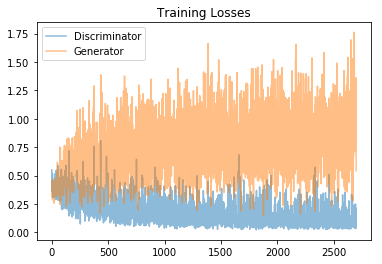

In [29]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [30]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [31]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

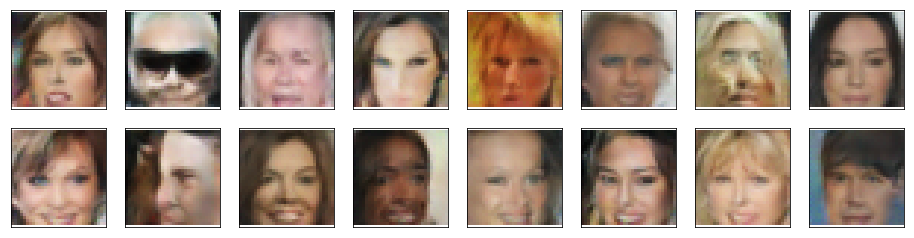

In [47]:
_ = view_samples(-1, samples)

In [48]:
out = D(samples[0])

In [49]:
out

tensor([[-0.1233],
        [-0.5413],
        [-0.5792],
        [-0.4166],
        [-0.4765],
        [-0.3227],
        [-0.8410],
        [-0.6048],
        [-0.2914],
        [-0.5148],
        [-0.0310],
        [-0.7887],
        [-0.2512],
        [-0.1474],
        [-0.5019],
        [-0.4943]], device='cuda:0')

In [50]:
torch.mean(out)

tensor(-0.4329, device='cuda:0')

In [34]:
import os

In [36]:
G_path = os.path.join('Untitled Folder', 'G.pkl')
D_path = os.path.join('Untitled Folder', 'D.pkl')
torch.save(G.state_dict(), G_path)
torch.save(D.state_dict(), D_path)

## Generating New Images

In [37]:
z = np.random.uniform(-1, 1, size=(batch_size, z_size))
z = torch.from_numpy(z).float()
            
if train_on_gpu:
    z = z.cuda()

In [38]:
output = G(z)

In [40]:
output.shape

torch.Size([20, 3, 32, 32])

In [51]:
new_samples = []

In [52]:
new_samples.append(output)

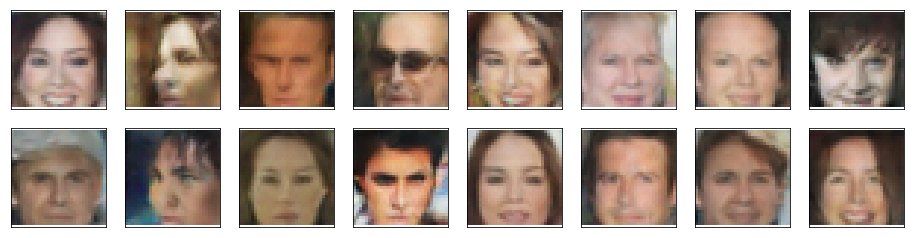

In [54]:
_ = view_samples(-1, new_samples)

## Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

As the dataset is biased it generates only white faces, this can be improved by collecting balanced dataset. We can improve model by using more layers in both Generator and Discriminator. Input images size can be increased for better results and training for more epochs.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.